In [ ]:
# default_exp cells
%load_ext autoreload
%autoreload 2

# Cells
> Combine exposure, and list of weighted photons to create cells for likelihood calculation

A list of cells, represented with a DataFrame, has the following columns

- t, tw : time (in MJD) an width of the cell
- e : the exposure, relative to the expection for the cell size
- n : the number of photons
- w : a list of weights, either float32, or  uint8 numbers: divide by 256 for the values
- S,B : expected values for the sums of w and (1-w) for the cell

Note that  w, S and B are needed for defining the likelihood.

Implemented here:

- `get_cells` -- return such a set for a given source.
- `partition_cells` -- combine a set of cells with a partition, as in the Bayesian Block analysis

In [ ]:
#hide
from nbdev.showdoc import show_doc

In [ ]:
#export
import os
import numpy as np
import pandas as pd
from wtlike.config import Config,  PointSource, Cache
from wtlike.photon_data import get_photon_data
from wtlike.weights import add_weights, check_weights
from wtlike.exposure import get_exposure, get_binned_exposure, get_default_bins

Create the binned exposure, and make a histogram of its output, the exposure per bin
relative to the aveage. 

Loading photon data for using source Geminga to test adding weights
Photon data: Saving to cache with key "photons_Geminga"
Processing 11 FITS files with GTI information ...  11 files, 63635 intervals with 3,322 days live time
Loading  132 months from Arrow dataset /home/burnett/data/dataset
....................................................................................................................................
	Selected 1,863,406 photons within 7 deg of  (195.13,4.27)
	Energies: 100.0-1000000 MeV
	Dates:    2008-08-04 15:46 - 2019-08-03 01:17
	MJD  :    54682.7          - 58698.1         
Load weights from file /mnt/c/users/thbur/OneDrive/fermi/weight_files/Geminga_weights.pkl
	Found: PSR J0633+1746 at (195.14, 4.27)
	Applyng weights: 420955 / 1863406 photon pixels are outside weight region
	686449 weights set to NaN
binned exposure for source Geminga: Saving to cache with key "binexp_Geminga"
exposure for Geminga: Saving to cache with key "exposure_Geminga"
Processing 13 S

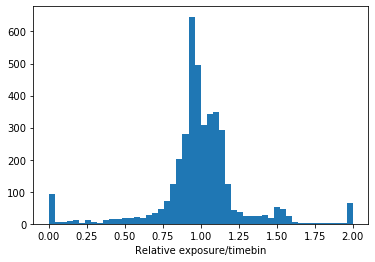

In [ ]:

config = Config()
source = PointSource('Geminga')

if config.valid:
    print(f'Loading photon data for using source {source.name} to test adding weights')
    check_weights(config, source)
    photon_data = get_photon_data(config, source )
    add_weights(config, photon_data, source)
    binned_exposure, time_bins = get_binned_exposure(config, source)
    
    plt.hist(binned_exposure.clip(0,2), 50, histtype='stepfilled');
    plt.xlabel('Relative exposure/timebin');
else:
    print('Not testing since no files.')


In [ ]:
#export
class _WeightedCells(object):
    """ Generate a list of cells, with access to cell data
        weights
    """

    def __init__(self, config, source,
                 photon_data:'DataFrame with photon data',
                 bins: 'time bins default if None'=None,
                ):
        """
        Use time binning photon_data to generate list of cells
        """
        self.source_name =source.name
        self.verbose = config.verbose
        self.use_uint8  = config.use_uint8
        
        # exposure binned as well
        self.fexposure, bins = get_binned_exposure(config, source=source, time_bins=bins, ) #bins, exposure)

        # manage bins 
        self.N = len(bins)-1 # number of bins
        self.bins = bins
        self.bin_centers = 0.5*(bins[1:]+bins[:-1])
        
        # restrict photons to range of bin times
        photons = photon_data.query(f'{bins[0]}<time<{bins[-1]}')

        # get the photon data with good weights, not NaN
        w = photons.weight
        good = np.logical_not(np.isnan(w))
        self.photons = photons.loc[good]
        self.weights = w = self.photons.weight.values
        
        # estimates for averate signal and background per cell
        self.S = np.sum(w)/self.N
        self.B = np.sum(1-w)/self.N

        # use photon times to get indices of bin edges
        self._edges = np.searchsorted(self.photons.time, bins)


    def __repr__(self):
        return f'''{self.__class__}:
        {len(self.fexposure)} intervals from {self.bins[0]:.1f} to {self.bins[-1]:.1f} for source {self.source_name}
        S {self.S:.2f}  B {self.B:.2f} '''

    def __getitem__(self, i):
        """ get info for ith time bin and return dict with
            t : MJD
            tw: bin width,
            e: exposure as fraction of total,
            n : number of photons in bin
            w : list of weights as uint8 integers<=255
            S,B:  value
        """
        k   = self._edges
        w = self.weights[k[i]:k[i+1]]
        wts = np.array(w*256, np.uint8) if self.use_uint8 else w
        n = len(wts)
        e = self.fexposure[i]
        tw  = self.bins[i+1]-self.bins[i]

        return dict(
                t=self.bin_centers[i], # time
                tw = tw,  # bin width
                e=e, # moving to this name
                n=n, # number of photons in bin
                w=wts,
                S= e *self.S,
                B= e *self.B,
                )

    def __len__(self):
        return self.N

    @property
    def dataframe(self):
        """ combine all cells into a dataframe
        """
        df = pd.DataFrame([cell for cell in self])
        return df


In [ ]:
#export
def get_cells(config,  source, bins=None, key=''):
    """Return a cells DataFrame for the source
    
    - source -- `PointSource` object
    - bins -- None, or an array of bin edges to define cells. If None use the default defined in config
    
  
    """
    def doit(config, source, bins):
        photon_data = get_photon_data(config,   source )
        add_weights(config,  photon_data, source)

        return _WeightedCells(config, source,photon_data, bins).dataframe
    
    key = f'cells_{source.name}' if key=='' else  key 
    description = f'Cell data for {source.name}' if config.verbose>0 and key is not None else ''

    return config.cache(key, doit, config, source, bins, description=description)

In [ ]:
show_doc(get_cells)

<h4 id="get_cells" class="doc_header"><code>get_cells</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>get_cells</code>(**`config`**, **`source`**, **`bins`**=*`None`*, **`key`**=*`''`*)

Return a cells DataFrame for the source

- source -- [`PointSource`](wtlike/config#PointSource) object
- bins -- None, or an array of bin edges to define cells. If None use the default defined in config

Create a table of cells

In [ ]:

if config.valid:
    cells = get_cells(config, source, key=None)

Photon data: Restoring from cache with key "photons_Geminga"

	Selected 1,863,406 photons within 7 deg of  (195.13,4.27)
	Energies: 100.0-1000000 MeV
	Dates:    2008-08-04 15:46 - 2019-08-03 01:17
	MJD  :    54682.7          - 58698.1         
Load weights from file /mnt/c/users/thbur/OneDrive/fermi/weight_files/Geminga_weights.pkl
	Found: PSR J0633+1746 at (195.14, 4.27)
	Applyng weights: 420955 / 1863406 photon pixels are outside weight region
	686449 weights set to NaN
binned exposure for source Geminga: Restoring from cache with key "binexp_Geminga"


A look at the contents of the first cell

In [ ]:
if config.valid:
    print(pd.Series(cells.iloc[0]))


t                                               5.5e+04
tw                                                    1
e                                                   1.3
n                                                   356
w     [0.95343286, 0.83939403, 0.68349504, 0.0219892...
S                                               2.3e+02
B                                               1.4e+02
Name: 0, dtype: object


An important check of the procedure is a comparison of the sum of weights in a cell with the exposure for that time interval.

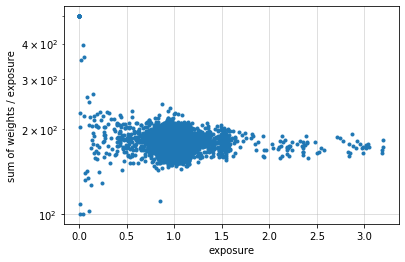

In [ ]:
#collapse_input
if config.valid:
    # check sums
    S = np.sum(cells.S.values)
    B = np.sum(cells.B.values)
    n = np.sum(cells.n)
    assert np.abs((S+B)/n -1)  < 0.1, f'Failed count check: total counts, {n}  shouuld be same as S+B,  {S+B}'
    wsum = cells.w.apply(np.sum)
    if config.use_uint8: w/= 256.;
    plt.semilogy(cells.e, (wsum/cells.e).clip(1e2,5e2), '.');
    plt.xlabel('exposure')
    plt.ylabel('sum of weights / exposure');
    plt.grid(alpha=0.5)

In [ ]:
#export 
def concatenate_cells( cells):
    """
    Combine a group of cells to one
    - cells: dataframe with cells containing  n, w, S, B<br>
            Optionally, if $t$ is present, generate t and tw
    Return a dict with summed n, S, B, and concatenated w
    """
    newcell = dict()
    if 't' in cells:
        ca, cb =cells.iloc[0], cells.iloc[-1]
        newcell.update(dict(t= 0.5*(ca.t-ca.tw/2 + cb.t+cb.tw/2), tw=cb.t-ca.t ))

    for col in ' n S B'.split():
        newcell[col] = cells[col].sum()
    newcell['w'] = np.concatenate(list(cells.w.values))
    return newcell

In [ ]:
show_doc(concatenate_cells)

<h4 id="concatenate_cells" class="doc_header"><code>concatenate_cells</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>concatenate_cells</code>(**`cells`**)

Combine a group of cells to one
- cells: dataframe with cells containing  n, w, S, B<br>
        Optionally, if $t$ is present, generate t and tw
Return a dict with summed n, S, B, and concatenated w

#### Test combination

In [ ]:
#collapse-#hide
if Config().valid:
    onecell = concatenate_cells(cells)
    pd.Series(onecell)

In [ ]:
#export
def partition_cells(config, cells, edges):
    """ Partition a set of cells
     - cells -- A DataFrame of cells
     - edges  -- a list of edges delimiting boundaries between cells
    """
    # should check limitsk
    ii = np.searchsorted(cells.t, edges)
    
    newcells = []
    for k in range(len(ii)-1):
        a,b = ii[k:k+2]
        subset = cells.iloc[a:b]; 

        ca, cb = subset.iloc[0], subset.iloc[-1]
        newcell = dict(t= 0.5*(ca.t-ca.tw/2 + cb.t+cb.tw/2)  )

        for col in 'tw e n S B'.split():
            newcell[col] = subset[col].sum()
        newcell['e'] /= len(subset)
        newcell['w'] = np.concatenate(list(subset.w.values)) #np.array(w, np.uint8)
        newcells.append(newcell)
    return pd.DataFrame(newcells)        
    

In [ ]:
show_doc(partition_cells)

<h4 id="partition_cells" class="doc_header"><code>partition_cells</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>partition_cells</code>(**`config`**, **`cells`**, **`edges`**)

Partition a set of cells
- cells -- A DataFrame of cells
- edges  -- a list of edges delimiting boundaries between cells

In [ ]:
if config.valid:
    print('Test partition by selecting subset of current bin edges')
    edges = cells.t.values-cells.tw.values/2
    width = 4
    newbins = edges[:20:width ];
    pd.set_option('display.precision',2 )
    pd.set_option('display.max_seq_items',4 )
    newcells = partition_cells(config, cells, newbins)
    print(newcells)

Test partition by selecting subset of current bin edges
         t   tw     e     n       S       B  \
0  54685.0  4.0  1.27  1506  910.17  576.15   
1  54689.0  4.0  1.27  1500  911.65  577.09   
2  54693.0  4.0  1.07  1317  770.74  487.89   
3  54697.0  4.0  0.89  1013  640.48  405.43   

                                                   w  
0  [0.95343286, 0.83939403, 0.68349504, 0.0219892...  
1  [0.03853981, 0.038505126, 0.15516773, 0.962390...  
2  [0.9380934, 0.13239114, 0.9046178, 0.08604455,...  
3  [0.58639663, 0.16927844, 0.72475386, 0.9188949...  


In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01-data_man.ipynb.
Converted 01_effective_area.ipynb.
Converted 02-source_data.ipynb.
Converted 02_gti.ipynb.
Converted 03_exposure.ipynb.
Converted 04_photon_data.ipynb.
Converted 05_weights.ipynb.
Converted 06_poisson.ipynb.
Converted 07_cells.ipynb.
Converted 08_loglike.ipynb.
Converted 09_lightcurve.ipynb.
Converted 10_simulation.ipynb.
Converted 14_bayesian.ipynb.
Converted index.ipynb.
Mon Mar 29 10:11:33 PDT 2021
